# Elementary Air Conditioning Processes (Part 2)
---

In [1]:
from deps import load_packages

load_packages()

In [2]:
import jupyter_addons as ja
ja.set_css()

This chapter further explores the use of the `AirConditioningProcess` class by solving sample exercises from the book **Principles of Heating, Ventilation and Air Conditioning** by *Nihal E Wijeysundera* (2016), Chapter 5.

In [3]:
from hvac import Quantity
from hvac.fluids import HumidAir, Fluid
from hvac.charts import PsychrometricChart, StatePoint
from hvac.air_conditioning import AirConditioningProcess, AirStream, AdiabaticMixing

In [4]:
Q_ = Quantity
Water = Fluid('Water')

## 1. Adiabatic Mixing

*In an air conditioning system return air at 26°C dry-bulb temperature and 50% relative humidity is mixed with outdoor ambient air at 34°C dry-bulb temperature and 60% relative humidity. The dry air mass flow rate of outdoor air is 30% of the supply air mass flow rate to the space. The pressure is constant at 101.3 kPa. Calculate (1) the enthalpy, (2) the humidity ratio, and (3) the dry-bulb temperature of the supply air.*

**Return air**
- dry-bulb temperature `Tdb` = 26°C
- relative humidity `RH` = 50%

In [5]:
return_air_state = HumidAir(Tdb=Q_(26.0, 'degC'), RH=Q_(50.0, 'pct'))

**Outdoor ambient air**

- dry-bulb temperature `Tdb` = 34°C
- relative humidity `RH` = 60%

In [6]:
outdoor_air_state = HumidAir(Tdb=Q_(34.0, 'degC'), RH=Q_(60.0, 'pct'))

**Mass flow rates of dry-air**
- outdoor air = 0.3 kg/s
- return air = 1.0 - 0.3 = 0.7 kg/s
- supply air = 1.0 kg/s

The adiabatic mixing of two air streams is modeled by the `AdiabaticMixing` class. Air streams are modeled by the `AirStream` class. An `AirStream` instance combines the air state and the mass flow rate of an air stream. The state and mass flow rate of the return air stream and the outdoor air stream are known. We know already the mass flow rate of the resulting supply air stream, but we still need to find its state. We initialize the three air streams with the data that we have at this stage:

In [7]:
return_air = AirStream(state=return_air_state, m_da=Q_(0.7, 'kg / s'))
outdoor_air = AirStream(state=outdoor_air_state, m_da=Q_(0.3, 'kg / s'))
supply_air = AirStream(m_da=Q_(1.0, 'kg / s'))

**Adiabatic mixing**

The `AdiabaticMixing` class can handle the adiabatic mixing of two incoming air streams (`in1` and `in2`), in this case the adiabatic mixing of return air and outdoor air in a mixing chamber. The outgoing air stream, which in this case is the supply air, of which only the mass flow rate is known at this moment, is assigned to parameter `out`.

In [8]:
mixing_chamber = AdiabaticMixing(in1=outdoor_air, in2=return_air, out=supply_air)

**Supply air**

The missing supply air state is immediately solved for on instantiation of the `AdiabaticMixing` class. The full solution for the supply air stream is then available through the property `stream_out` of the `AdiabaticMixing` instance. 

In [9]:
supply_air = mixing_chamber.stream_out

ja.display_list([
    f"enthalpy of supply air = <b>{supply_air.state.h.to('kJ / kg'):~P.3f}</b>",
    f"humidity ratio of supply air = <b>{supply_air.state.W.to('g / kg'):~P.1f}</b>",
    f"dry-bulb temperature of supply air = <b>{supply_air.state.Tdb.to('degC'):~P.1f}</b>"
])

## 2. Adiabatic Mixing and Heating

*In a winter air conditioning system, outdoor air at 2°C and 20% relative humidity is mixed with return air at 23°C and 40% relative humidity. The ratio of the dry air mass flow rates of outdoor air to supply air is 1:4. The supply air is heated sensibly to a dry-bulb temperature of 35°C before being supplied to the space at the rate of 30 kg of dry air per minute. The pressure is constant at 101.3 kPa. Calculate (1) the wet-bulb temperature of the air after the mixing process, (2) the relative humidity of the air supplied to the space, and (3) the rate of heat input to the heater.*

**Outdoor air**

- dry-bulb temperature `Tdb` = 2°C
- relative humidity `RH` = 20%

In [10]:
outdoor_air_state = HumidAir(Tdb=Q_(2.0, 'degC'), RH=Q_(20, 'pct'))

**Return air**

- dry-bulb temperature `Tdb` = 23°C
- relative humidity `RH` = 40%

In [11]:
return_air_state = HumidAir(Tdb=Q_(23.0, 'degC'), RH=Q_(40, 'pct'))

**Mass flow rates of dry air**

- `m_da` outdoor air = 0.25 x 30.0 kg/min
- `m_da` return air = 0.75 x 30.0 kg/min
- `m_da` supply air = 30.0 kg/min

**Adiabatic mixing**

In [12]:
outdoor_air = AirStream(state=outdoor_air_state, m_da=Q_(0.25 * 30.0, 'kg / min'))
return_air = AirStream(state=return_air_state, m_da=Q_(0.75 * 30.0, 'kg / min'))
mixed_air = AirStream(m_da=Q_(30.0, 'kg / min'))

mixing_chamber = AdiabaticMixing(in1=outdoor_air, in2=return_air, out=mixed_air)

**Supply air before heater**

In [13]:
mixed_air_state = mixing_chamber.stream_out.state

ja.display_list([
    f"wet-bulb temperature of supply air before heater= <b>{mixed_air_state.Twb.to('degC'):~P.1f}</b>"
])

**Supply air after heater**

- dry-bulb temperature `Tdb` of supply air after heater = 35°C
- sensible heating process: humidity ratio `W` remains constant

In [14]:
supply_air_state = HumidAir(Tdb=Q_(35.0, 'degC'), W=mixed_air_state.W)

ja.display_list([
    f"relative humidity of supply air after heater= <b>{supply_air_state.RH.to('pct'):~P.0f}</b>"
])

**Sensible heating process**

In a sensible heating process there is no water transfer to the air stream. Therefore, we set the mass transfer of water `m_w` and the enthalpy of water `h_w` to zero.

In [15]:
heater = AirConditioningProcess(
    air_in=mixed_air_state,
    air_out=supply_air_state,
    m_da=Q_(30.0, 'kg / min'),
    m_w=Q_(0.0, 'kg / min'),
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"rate of heat input to the heater = <b>{heater.Q.to('kW'):~P.3f}</b>"
])

## 3. Adiabatic Mixing and Cooling

*In a summer air conditioning system, 25% of the return air from a space at 30°C dry-bulb (db) temperature, and 22°C wet-bulb (wb) temperature is exhausted and an equal quantity of fresh air at 34°C db-temperature, and 28°C wb-temperature is mixed with the remaining return air. The mixture passes over a cooling coil whose coil-surface temperature (apparatus dew-point) is 8°C and the bypass factor is 0.25. The mass flow rate of dry air to the space is 0.8 kg/s. The pressure is constant at 101.3 kPa. Calculate (1) db-temperature and the relative humidity of the air leaving the cooling coil, (2) enthalpy-humidity ratio of the cooling process, and (3) the refrigeration capacity of the cooling coil.*

**Return air**

In [16]:
return_air_state = HumidAir(Tdb=Q_(30.0, 'degC'), Twb=Q_(22.0, 'degC'))

**Outdoor air**

In [17]:
outdoor_air_state = HumidAir(Tdb=Q_(34.0, 'degC'), Twb=Q_(28.0, 'degC'))

**Mass flow rates of dry air**

- supply air to space = 0.8 kg/s
- outdoor air = 0.25 x 0.8 kg/s
- return air = 0.75 x 0.8 kg/s

**Adiabatic mixing**

In [18]:
outdoor_air = AirStream(state=outdoor_air_state, m_da=Q_(0.25 * 0.8, 'kg / s'))
return_air = AirStream(state=return_air_state, m_da=Q_(0.75 * 0.8, 'kg / s'))
mixed_air = AirStream(m_da=Q_(0.8, 'kg / s'))

mixing_chamber = AdiabaticMixing(in1=outdoor_air, in2=return_air, out=mixed_air)

**Supply air before cooler**

In [19]:
mixed_air_state = mixing_chamber.stream_out.state

**Air cooling process**

In [20]:
air_cooler = AirConditioningProcess(
    air_in=mixed_air_state,
    ADP=HumidAir(Tdb=Q_(8.0, 'degC'), RH=Q_(100.0, 'pct')),
    beta=Q_(1.0 - 0.25, 'frac'),  # contact-factor = 1 - bypass-factor
    m_da=Q_(0.8, 'kg / s'),
    h_w=Q_(0.0, 'J / kg')  # we ignore the enthalpy of the condensing water from the air stream
)

ja.display_list([
    f"refrigeration capacity of the cooling coil = <b>{air_cooler.Q.to('kW'):~P.3f}</b>"
])

**Supply air after cooler**

In [21]:
supply_air = air_cooler.air_out

ja.display_list([
    f"dry-bulb temperature of air leaving the cooler = <b>{supply_air.Tdb.to('degC'):~P.1f}</b>",
    f"relative humidity of air leaving the cooler = <b>{supply_air.RH.to('pct'):~P.0f}</b>"
])

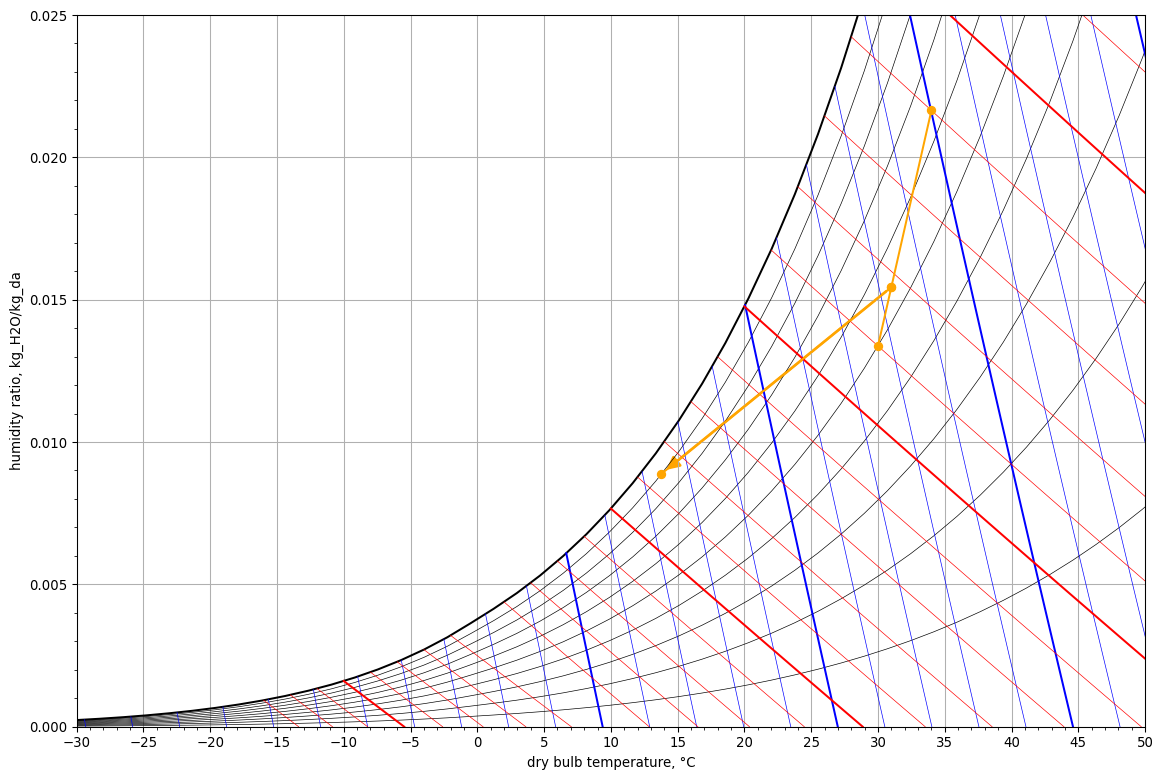

In [22]:
psych_chart = PsychrometricChart()

psych_chart.plot_process(
    name='adiabatic mixing',
    start_point=StatePoint(outdoor_air.Tdb, outdoor_air.W),
    end_point=StatePoint(return_air.Tdb, return_air.W),
    mix_point=StatePoint(mixed_air.Tdb, mixed_air.W)
)

psych_chart.plot_process(
    name='air cooler',
    start_point=StatePoint(mixed_air.Tdb, mixed_air.W),
    end_point=StatePoint(supply_air.Tdb, supply_air.W)
)

psych_chart.show()

## 4. Evaporative Cooling

*Ambient air at 38°C db-temperature and 20°C wb-temperature enters an evaporative cooler with a dry air mass flow rate of 0.75 kg/s. The pressure is constant at 95 kPa. The air leaves at a db-temperature of 25°C. Calculate (1) the relative humidity of the air at inlet, (2) the relative humidity of the air at exit, (3) the rate of flow of water to the cooler, and (4) the saturation effectiveness of the cooler.*

Notice that the atmospheric pressure is given to be 95 kPa, instead of the standard atmospheric pressure (101.325 kPa). Therefore, we must specify that the properties of moist air need to be calculated at a pressure of 95 kPa.

**State of entering air**

In [23]:
air_in = HumidAir(Tdb=Q_(38.0, 'degC'), Twb=Q_(20.0, 'degC'), P=Q_(95, 'kPa'))

ja.display_list([
    f"relative humidity of the air at inlet = <b>{air_in.RH.to('pct'):~P.0f}</b>"
])

**State of leaving air**

<mark>Evaporative cooling is known to be a constant wet-bulb temperature process</mark>. So the wet-bulb temperature of the leaving air will be the same as that of the entering air.

In [24]:
air_out = HumidAir(Tdb=Q_(25.0, 'degC'), Twb=air_in.Twb, P=Q_(95, 'kPa'))

ja.display_list([
    f"relative humidity of the air at outlet = <b>{air_out.RH.to('pct'):~P.0f}</b>"
])

**Enthalpy of water**

We assume that under steady-state the liquid water being supplied to the cooler has a temperature that is equal to the wet-bulb temperature of the process. The wet-bulb temperature of the entering air can be considered as the lowest temperature that can be attained by evaporative cooling in an adiabatic saturator.

In [26]:
water = Water(T=Q_(20.0, 'degC'), P=Q_(95.0, 'kPa'))
h_w = water.h

**Saturated state of leaving air: ADP**

In an adiabatic saturator (i.e. the most efficient evaporative cooler) the air stream would continue to absorb water vapor, while being further cooled due to the evaporation of water that is taking sensible heat from the air, until the air is fully saturated. Once the air is fully saturated (RH = 100%), the energy transfer between air and water will cease, as the air cannot take up any more water vapor. At this saturated state the dry-bulb temperature of the air stream at the outlet of the adiabatic saturator will be maximally reduced to the wet-bulb temperature. This saturated state is here denoted by `ADP`, in analogy with the "Apparatus Dew Point" of an air cooler.

In [28]:
air_adp = HumidAir(Tdb=air_in.Twb, RH=Q_(100.0, 'pct'))

**Evaporative cooling**

In an evaporative cooler there is no heat transfer between the system of air and water and its environment, so `Q` must be set to zero. From the heat balance the mass flow rate `m_w` at which water evaporates in the air stream can be solved. To get the saturation effectiveness of the evaporative cooler, we need to pass the `ADP` state of the air (i.e. the saturated state of the air that would be attained in an adiabatic saturator). The saturation effectiveness is here denoted by `beta`, in analogy with the contact factor of an air cooling coil.

In [29]:
cooler = AirConditioningProcess(
    air_in=air_in,
    air_out=air_out,
    m_da=Q_(0.75, 'kg / s'),
    h_w=h_w,
    Q=Q_(0.0, 'W'),
    ADP=air_adp
)

ja.display_list([
    f"flow rate of evaporating water to the air stream = <b>{cooler.m_w.to('kg / s'):~P.3f}</b>",
    f"saturation effectiveness of the cooler = <b>{cooler.beta.to('frac'):~P.2f}</b>"
])

## 5. Space Cooling

*The rate of sensible heat gain and the rate of moisture gain by a space are 23 kW and 0.0024 kg/s respectively. The space is maintained at 24°C db-temperature and 50% relative humidity. The air supplied to the space is at a db-temperature of 15°C. Assume that the moisture entering the space has an enthalpy of 2555 kJ/kg. The pressure is constant at 101.3 kPa. Calculate (1) the relative humidity, the wb-temperature, and the dry air mass flow rate of air supplied, (2) the refrigeration capacity of the cooling coil, and (3) the bypass factor and the apparatus dew-point of the cooling coil.*

**Sensible and latent heat load of the room**

In [30]:
Q_sen = Q_(23.0, 'kW')

The latent heat gain of the room can be approximated by $Q_{lat} = m_w . h_{wg}$ wherein $h_{wg}$ is the mean enthalpy of water vapor between 0 and 60 °C and equal to 2555 kJ/kg.

In [31]:
Q_lat = Q_(0.0024, 'kg / s') * Q_(2555, 'kJ / kg')

From the sensible and latent heat gain, the sensible heat ratio (SHR) of the room can be determined:

In [32]:
SHR = Q_sen / (Q_sen + Q_lat)

In [33]:
ja.display_list([
    f"latent heat load of the room = <b>{Q_lat.to('kW'):~P.3f}</b>",
    f"sensible heat ratio of the room = <b>{SHR.to('pct'):~P.3f}</b>"
])

**Supply air dry-bulb temperature**

In [34]:
T_sup = Q_(15.0, 'degC')

**Room air = return air to cooler**

In [35]:
return_air = HumidAir(Tdb=Q_(24.0, 'degC'), RH=Q_(50.0, 'pct'))

**Complete thermodynamic state of supply air and mass flow rate of dry air**

The SHR of the room determines the slope $\Delta W / \Delta T$ of the "space condition line" in the psychrometric diagram. The state of the supply air must lie on this line. As the dry-bulb temperature of the supply air is given and the state of the room air is known, the equation of the space condition line can be solved for the missing humidity ratio of the supply air.

From the sensible heat balance, the mass flow rate of dry air `m_da` can be solved, knowing the dry-bulb temperatures of supply and return air and the sensible heat load `Q_sen` of the room.

In [36]:
room = AirConditioningProcess(
    T_ai=T_sup,
    air_out=return_air,
    SHR=SHR,
    Q_sen=Q_sen
)

supply_air = room.air_in

m_da = room.m_da

ja.display_list([
    f"relative humidity of air supplied = <b>{supply_air.RH.to('pct'):~P.0f}</b>",
    f"wet-bulb temperature of air supplied = <b>{supply_air.Twb.to('degC'):~P.1f}</b>",
    f"mass flow rate of dry air = <b>{m_da.to('kg / s'):~P.3f}</b>"
])

**Refrigeration capacity of the air cooler**

The return air from the room enters the cooler and the supply air to the room leaves the cooler. We will ignore the enthalpy of the condensate in the cooler, so we set `h_w` to zero.

In [39]:
cooler = AirConditioningProcess(
    air_in=return_air,
    air_out=supply_air,
    m_da=m_da,
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"refrigeration capacity of cooler = <b>{cooler.Q.to('kW'):~P.3f}</b>",
    f"ADP of cooler = <b>{cooler.ADP.Tdb.to('degC'):~P.1f}, {cooler.ADP.W.to('g / kg'):~P.0f}</b>",
    f"bypass factor of cooler = <b>{(1 - cooler.beta).to('pct'):~P.1f}</b>"
])

## 6. Space Cooling with Reheat

*A summer air conditioning system, consisting of a cooling coil and a reheat coil, supplies air to a space maintained at 24°C db-temperature and 18°C wb-temperature. The sensible and latent heat loads on the space are 11 kW and 10 kW respectively. The conditions of the air leaving the cooling coil are 12°C db-temperature and 90% relative humidity. The pressure is constant at 101.3 kPa. Determine (1) the db-temperature and wb-temperature of the supply air, (2) the dry air mass flow rate of the air supplied, (3) the refrigeration capacity of the cooling coil, (4) the rate of heat input by the reheat coil, and (5) the bypass factor and apparatus dew-point of the cooling coil.*

**Space air**

In [40]:
space_air = HumidAir(Tdb=Q_(24.0, 'degC'), Twb=Q_(18.0, 'degC'))

**Sensible and latent heat load of space**

In [41]:
Q_sen = Q_(11, 'kW')
Q_lat = Q_(10, 'kW')
SHR = Q_sen / (Q_sen + Q_lat)

**Air cooler outlet**

In [42]:
cooler_out = HumidAir(Tdb=Q_(12.0, 'degC'), RH=Q_(90.0, 'pct'))

**State and mass flow rate of supply air to the space**

The state of the space air (`air_out`) and the SHR of the space determine the "space condition line". The humidity ratio of the entering supply air (`W_ai`) is known, as the humidity ratio of the air leaving the air cooler will remain constant through the reheat coil, which is a sensible heating process. From the equation of the space condition line, the unknown dry-bulb temperature of the supply air can be solved for. Putting this result in the sensible heat balance of the space, will give us the required mass flow rate of supply air, as we know the sensible heat load (`Q_sen`) of the space.

In [43]:
space = AirConditioningProcess(
    air_out=space_air,
    W_ai=cooler_out.W,
    SHR=SHR,
    Q_sen=Q_sen
)

supply_air = space.air_in

m_da = space.m_da

ja.display_list([
    f"dry-bulb temperature of supply air to space = <b>{supply_air.Tdb.to('degC'):~P.1f}</b>",
    f"wet-bulb temperature of supply air to space = <b>{supply_air.Twb.to('degC'):~P.1f}</b>",
    f"mass flow rate of dry air = <b>{m_da.to('kg / s'):~P.3f}</b>"
])

**Air cooler**

In [44]:
cooler = AirConditioningProcess(
    air_in=space_air,
    air_out=cooler_out,
    m_da=m_da,
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"refrigeration capacity of air cooler = <b>{cooler.Q.to('kW'):~P.3f}</b>",
    f"apparatus dew-point of cooling coil = <b>{cooler.ADP.Tdb.to('degC'):~P.1f}</b>",
    f"bypass factor of air cooler = <b>{1 - cooler.beta.to('frac'):~P.2f}</b>"
])

**Reheat coil**

In [45]:
reheater = AirConditioningProcess(
    air_in=cooler_out,
    air_out=supply_air,
    m_da=m_da,
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"rate of heat input by the reheat coil = <b>{reheater.Q.to('kW'):~P.3f}</b>"
])

**Check the overall energy balance**

The sum of heat removed from the system by the cooling coil and the energy supplied by the reheating coil should balance the total heat load on the space (= `Q_sen` + `Q_lat`).

In [46]:
ja.display_list([
    f"Net heat removed from the system = <b>{cooler.Q.to('kW') + reheater.Q.to('kW'):~P.3f}</b>"
])

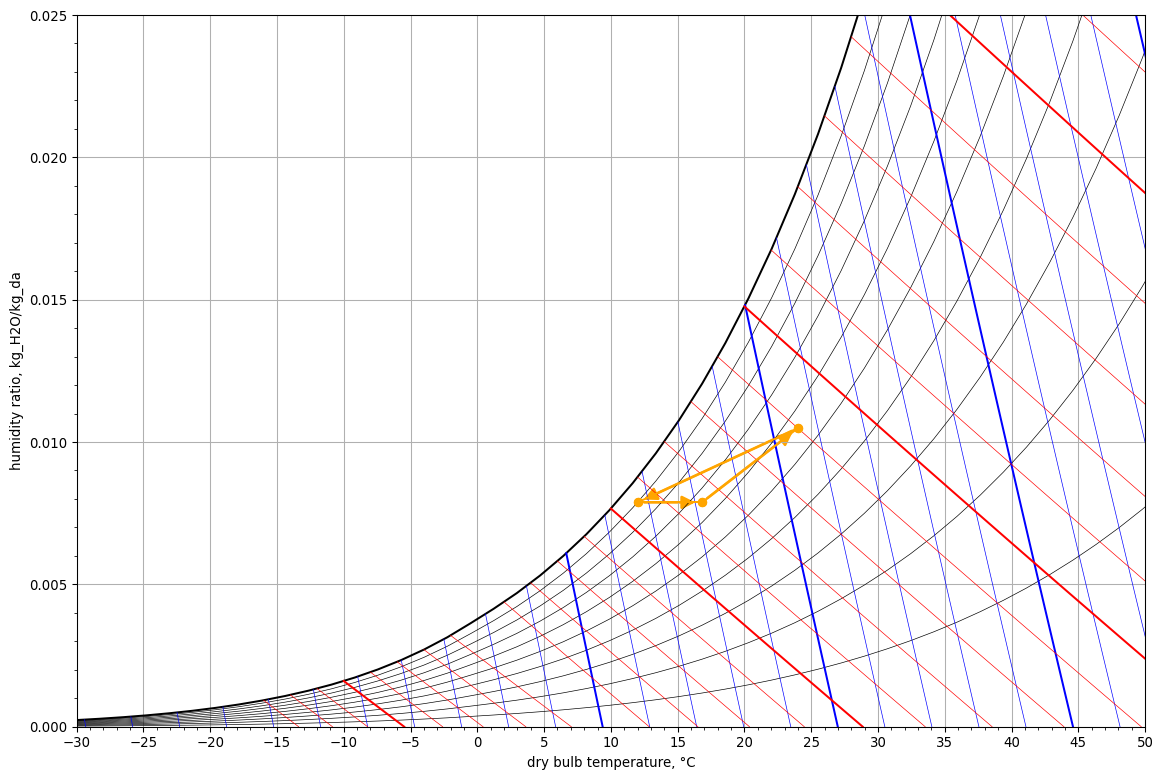

In [47]:
psych_chart = PsychrometricChart()

psych_chart.plot_process(
    name='room',
    start_point=StatePoint(supply_air.Tdb, supply_air.W),
    end_point=StatePoint(space_air.Tdb, space_air.W),
)

psych_chart.plot_process(
    name='air cooler',
    start_point=StatePoint(space_air.Tdb, space_air.W),
    end_point=StatePoint(cooler_out.Tdb, cooler_out.W)
)

psych_chart.plot_process(
    name='reheater',
    start_point=StatePoint(cooler_out.Tdb, cooler_out.W),
    end_point=StatePoint(supply_air.Tdb, supply_air.W)
)

psych_chart.show()

## 7. Space Cooling with Ventilation and Return Air Bypass

*An air conditioning system supplying air to a space with a sensible heat load of 14 kW and a latent heat load of 9 kW has a cooling coil and a bypass path downstream of the cooling coil for direct recirculation of return air back to the space. The db-temperature of the space is maintained at 26°C. The dry air mass flow rate of supply air is 1.2 kg/s. Outdoor ventilation air at 34°C db-temperature and 50 % relative humidity is introduced into the system with a dry air mass flow rate of 0.26 kg/s. The air leaving the cooling coil is fully saturated at a db-temperature of 6°C. The pressure is constant at 101.3 kPa. Determine (1) db-temperature and relative humidity of the supply air to the space, (2) the wb-temperature of the space, (3) the temperature of the air entering the cooling coil, and (4) the refrigeration capacity of the cooling coil.*

**Sensible and latent heat load of the room**

In [48]:
Q_sen = Q_(14.0, 'kW')
Q_lat = Q_(9.0, 'kW')
SHR = Q_sen / (Q_sen + Q_lat)

**Mass flow rate of supply air to the room**

In [50]:
m_da_sup = Q_(1.2, 'kg / s')

**Dry-bulb temperature of room air = return air**

In [51]:
T_ret = Q_(26.0, 'degC')

**State of outdoor ventilation air and mass flow rate of ventilation air**

In [52]:
ven_air = HumidAir(Tdb=Q_(34.0, 'degC'), RH=Q_(50, 'pct'))
m_da_ven = Q_(0.26, 'kg / s')

**State of air leaving the cooling coil**

In [53]:
cooler_out_air = HumidAir(Tdb=Q_(6.0, 'degC'), RH=Q_(100, 'pct'))

**State of room air = return air**

The state of the supply air to the room is determined by adiabatic mixing of cooled air from the cooling coil with return air that comes from the bypass path. In the psychrometric diagram the process of adiabatic mixing is represented by a straight line. The state of the supply air lies somewhere on this straight line that connects the state of the air at the cooler outlet (which is known: `cooler_out_air`) with the state of the return air (of which only the dry-bulb temperature `T_ret` is known).<br>

In the psychrometric diagram the state of the supply air to the space and the state of the return air from the space also lie on a straight line, the space condition line, of which the slope is determined by the SHR of the room (which is known: `SHR`).

It then follows that the line of adiabatic mixing and the space condition line must coincide and have the same slope. This fact can now be used to find the complete thermodynamic state of the return air. For this we consider an air conditioning process of which the entering air is the air at the cooler outlet `cooler_out_air`, the slope of its condition line is determined by `SHR`, and the dry-bulb temperature of the leaving air is `T_ret`. With this input data the full state of the return air can be calculated from the equation of the space condition line.

In [54]:
p1 = AirConditioningProcess(
    air_in=cooler_out_air,
    T_ao=T_ret,
    SHR=SHR
)

return_air = p1.air_out

ja.display_list([
    f"wet-bulb temperature of room air = <b>{return_air.Twb.to('degC'):~P.1f}</b>"
])

**State of supply air**

With the state of the return air known, the state of the supply air can now be calculated from the sensible and latent heat balance of the room. The enthalpy of water `h_w` in the latent heat balance will be ignored.

In [55]:
p2 = AirConditioningProcess(
    air_out=return_air,
    m_da=m_da_sup,
    Q_sen=Q_sen,
    Q_lat=Q_lat,
    h_w=Q_(0.0, 'J / kg')
)

supply_air = p2.air_in

ja.display_list([
    f"dry-bulb temperature of supply air = <b>{supply_air.Tdb.to('degC'):~P.1f}</b>",
    f"relative humidity of supply air = <b>{supply_air.RH.to('pct'):~P.0f}</b>"
])

**Air mass flow rates through the air cooler and the bypass path**

At the mixing point of the cooling coil outlet and the bypass path, the state of the three air streams and the mass flow rate of only the mixed output stream, i.e. the supply air to the room, are known. With these input data the mass flow rates through the cooling coil and through the bypass path can be calculated.

In [56]:
bypass_stream = AirStream(state=return_air)
cooler_out_stream = AirStream(state=cooler_out_air)
supply_stream = AirStream(state=supply_air, m_da=m_da_sup)

mix1 = AdiabaticMixing(
    in1=bypass_stream,
    in2=cooler_out_stream,
    out=supply_stream
)

ja.display_list([
    f"mass flow rate of dry air through bypass = <b>{bypass_stream.m_da.to('kg / s'):~P.3f}</b>",
    f"mass flow rate of dry air through cooler = <b>{cooler_out_stream.m_da.to('kg / s'):~P.3f}</b>"
])

**Mass flow rate of recirculated return air upstream of the air cooler**

The mass flow rate of dry air at the cooler outlet is also the mass flow rate of return air that flows towards the cooler inlet. However, part of this air is also exhausted to the outside. From the problem statement it follows that 0.26 kg/s is exhausted to the outside (exhaust rate equals outdoor ventilation intake rate, as dictated by the law of conservation of mass at steady-state).

In [57]:
m_da_exh = m_da_ven

The mass flow rate of recirculated return air that flows to the mixing chamber upstream of the cooling coil is then:

In [58]:
m_da_rec = cooler_out_stream.m_da - m_da_exh

**Adiabatic mixing of return air and ventilation air at cooler inlet**

In [60]:
recirculated_stream = AirStream(state=return_air, m_da=m_da_rec)
ventilation_stream = AirStream(state=ven_air, m_da=m_da_ven)
cooler_in_stream = AirStream(m_da=cooler_out_stream.m_da)

mix2 = AdiabaticMixing(
    in1=recirculated_stream,
    in2=ventilation_stream,
    out=cooler_in_stream
)

cooler_in_air = mix2.stream_out.state

ja.display_list([
    f"temperature of the air entering the cooling coil = <b>{cooler_in_air.Tdb.to('degC'):~P.1f}</b>"
])

**Refrigeration capacity of cooling coil**

In [61]:
cooler = AirConditioningProcess(
    air_in=cooler_in_air,
    air_out=cooler_out_air,
    m_da=cooler_out_stream.m_da,
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"refrigeration capacity of cooling coil = <b>{cooler.Q.to('kW'):~P.3f}</b>"
])

**Checking the overall energy balance of the system**

- Sensible and latent heat gains are added to the system in the room. 
- Heat is added to the system by the outdoor ventilation air. This air must be cooled to room air conditions = <mark>ventilation load</mark>.
- Heat is extracted from the system in the cooling coil.

At steady-state the total heat added to the system must equal the total heat extracted from the system.

The ventilation load can be determined as follows:

In [62]:
h_i = ventilation_stream.state.h
h_f = return_air.h
Q_ven = m_da_ven * (h_i - h_f)

ja.display_list([
    f"ventilation load = <b>{Q_ven.to('kW'):~P.3f}</b>"
])

The total heat gain of the system can be determined as:

In [63]:
Q_gain = Q_sen + Q_lat + Q_ven

ja.display_list([
    f"total heat gain of the system = <b>{Q_gain.to('kW'):~P.3f}</b>"
])

It follows that the calculated refrigeration capacity of the cooling coil approximates the total heat gain of the system closely.